Кейс: a/b-тест для мобильного приложения.

Имеется мобильное приложение для магазина по продаже продуктов питания. Выдвинута гипотеза о том, что смена шрифтов улучшит качество обслуживания по количеству клиентов, совершающих каждое событие. Для проверки этой гипотезы принято решение провести A/B-тест.   

Договорились принять решение по результатам A/B-теста.
Пользователей разбили на 2 группы: 247 -- контрольная группа со старыми шрифтами; 248 -- экспериментальная с новыми шрифтами.

Описание данных

|Признак|Комментарий|
|--:|:--|
|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|

Инструкция по выполнению проекта

Шаг 1. Загрузите данные
- Знакомство с данными;
- Корректность a/b-теста.

Шаг 2. Подготовьте данные
- Корректировка заголовков;
- Типы данных;
- Аномалии пропуски.

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

Шаг 5. Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Посчитайте долю пользователей, совершивших каждое из событий.
- Проверьте гипотезу о наличие значимых отличий по результатам теста.

С помощью Yandex DataLens создайте дашборд, отвечащий на следующие вопросы:
- сколько уникальных клиентов в группах 247 и 248;
- сколько уникальных клиентов совершили события по каждой группе;
- по каждой группе построить распределение количества событий по времени.

Ссылку на дашборд прикрепите к настоящей тетради.

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from glob import glob

In [121]:
# загрузка данных
df = pd.read_csv('ab_testing.csv',
                 sep='\t')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [122]:
# информация о наборе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [123]:
df.groupby('ExpId').DeviceIDHash.nunique()

ExpId
246    2489
247    2520
248    2542
Name: DeviceIDHash, dtype: int64

In [124]:
# проверим корректность проведенного теста
# - объемы выборок по группам примерно совпадают -- количество уникальных субъектов по каждой группе, участвующих в эксперименте/тесте
df.groupby('ExpId').DeviceIDHash.nunique()

# - одни и те же клиенты не могут быть в разных группах
set_user_id_246 = set(df[df.ExpId == 246].DeviceIDHash) # множество уникальных id группы 246
set_user_id_248 = set(df[df.ExpId == 248].DeviceIDHash) # множество уникальных id группы 248

# проверим наличие общих клиентов в группах
set_user_id_246.intersection(set_user_id_248)

# проведенный a/b-тест является корректным.

# Пример удаления "общих" клиентов
# игрушечный набор данных
dct_to_df = {'id': [1, 2, 3, 3, 4, 4, 5, 6],
             'gr': ['a', 'a', 'a', 'b', 'a', 'b', 'b', 'b']}
df_temp  = pd.DataFrame(dct_to_df)
df_temp

# уникальные клиенты групп
set_user_id_a = set(df_temp[df_temp.gr == 'a'].id) # множество уникальных id группы a
set_user_id_b = set(df_temp[df_temp.gr == 'b'].id) # множество уникальных id группы b

# общие клиенты
lst_id_del = list(set_user_id_a.intersection(set_user_id_b))

# 1 способ
df_temp.loc[~df_temp.id.isin(lst_id_del)]

# 2 способ
index_del = df_temp.loc[df_temp.id.isin(lst_id_del)].index
df_temp.drop(index=index_del, inplace=True)
df_temp

,id,gr
0,1,a
1,2,a
6,5,b
7,6,b


In [125]:
df.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [126]:
# приводим заголовки к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')

In [127]:
# - исправим заголовки;

df.columns = ['event_name', 'user_id', 'event_time', 'group_id']

In [128]:
# корректировка типов данных
# 1 способ
df['event_time'] = pd.to_datetime(df['event_time'],
                                  unit='s',
                                  origin='unix')
# 2 способ
# df['event_time'] = df['event_time'].astype('datetime64[s]')
df.head(2)

,event_name,user_id,event_time,group_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246


In [129]:
# поиск дублей;
df.duplicated().sum()
lst_user_id_dupl = list(df.loc[df.duplicated()].user_id.unique())
df.drop_duplicates(keep='last',
                   inplace=True)

In [130]:
# поиск аномальных значений
# просмотр уникальных значений

lst_col = ['event_name', 'group_id']

def get_info_unique(lst:list):
    for col in lst_col:
        print(f'--- признак {col} ---')
        display(df[col].value_counts(ascending=False))
        print()

# событие -- Tutorial -- не имеет отношения к событиям покупки и его можно удалить

# найдем количество посещений на каждого клиента
user_id_top_10 = df.groupby('user_id')\
                   .agg(count_visits = ('user_id', 'count'))\
                   .reset_index()\
                   .sort_values(by='count_visits',
                                ascending=False)\
                   .head(10)\
                   .user_id\
                   .to_list()

# проверим наличие клиентов из топ-10 по посещениям в списке с дублями

def get_index(lst_user_id_dupl:list, user_id_top_10:list) -> list:
    return [id for id in user_id_top_10 if id in lst_user_id_dupl]

# клиенты из топ-10 с дублями
get_index(lst_user_id_dupl, user_id_top_10)

# удалим их
index_del = df.loc[df.user_id.isin(get_index(lst_user_id_dupl, user_id_top_10))]\
              .index
df.drop(index=index_del,
        inplace=True)

# событие -- Tutorial -- не имеет отношения к событиям покупки и его можно удалить
df.drop(index=df[df.event_name == 'Tutorial'].index,
        inplace=True)

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

In [131]:
print(f"""
Всего {df.event_name.nunique()} события -- {', '.join(df.event_name.unique())}.
Всего пользователей {df.user_id.nunique()}.
В среднем на пользователя приходится {int(df.shape[0] / df.user_id.nunique())} событий.""")


Всего 4 события -- MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear.
Всего пользователей 7540.
В среднем на пользователя приходится 30 событий.


In [132]:
# добавим признаки, связанные с датой
df['event_date'] = df['event_time'].dt.date
df.head(2)

,event_name,user_id,event_time,group_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25


In [133]:
print(f"""Дата начала теста -- {df['event_date'].min()}
Дата окончания теста -- {df['event_date'].max()}""")

Дата начала теста -- 2019-07-25
Дата окончания теста -- 2019-08-07


/tmp/ipykernel_7998/5233323.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



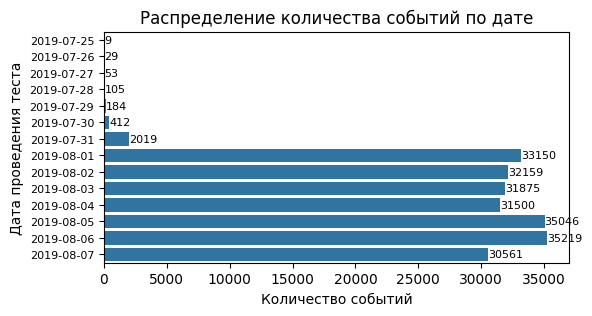

In [134]:
# Гистограмма по дате и количеству событий
plt.figure(figsize=(6,3))
ax = sns.countplot(data=df, y='event_date');
ax.set_title("Распределение количества событий по дате");
ax.set_ylabel("Дата проведения теста");
ax.set_xlabel("Количество событий");
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8);
ax.bar_label(ax.containers[0], fontsize=8);

In [135]:
# Из гистограммы следует, что первую неделю тест фактически не проводился,
# посколько клиенты по неизвестной причине не совершали никаких событий.
# Вывод, результаты полученные в ходе следует считать некорректными.

# Доделаем оставшиеся пункты проекта, предварительно удалив данные за первую неделю
df = df.loc[~(df.event_date <= dt.date(2019, 7, 31))].copy()

In [136]:
# проверка выполненной фильтрации

df.sort_values(by='event_date')

,event_name,user_id,event_time,group_id,event_date
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
26786,OffersScreenAppear,1832951734389458979,2019-08-01 15:37:30,246,2019-08-01
26785,MainScreenAppear,455812380260872971,2019-08-01 15:37:30,247,2019-08-01
26784,CartScreenAppear,1009745980451513098,2019-08-01 15:37:28,248,2019-08-01
26783,MainScreenAppear,2477577206728983149,2019-08-01 15:37:25,246,2019-08-01
...,...,...,...,...,...
223490,MainScreenAppear,1072623712787612806,2019-08-07 10:18:06,247,2019-08-07
223489,MainScreenAppear,5488760014591002030,2019-08-07 10:18:05,246,2019-08-07
223488,OffersScreenAppear,4612600107457375865,2019-08-07 10:18:04,248,2019-08-07
223500,PaymentScreenSuccessful,1072623712787612806,2019-08-07 10:18:15,247,2019-08-07


# Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки.
- На каком шаге теряете больше всего пользователей? Какая доля пользователей доходит от первого события до оплаты?

In [137]:
# Распределение событий: какие события и в каком количестве.
# Сколько пользователей совершали каждое из этих событий?
# исключим клиентов 247 группы

df_funnel = df[df.group_id != 247].groupby('event_name')\
                                  .agg(event_count=('user_id', 'count'),
                                       event_user_id_unique=('user_id', 'nunique'))\
                                  .reset_index()\
                                  .sort_values(by='event_count', ascending=False)

<Axes: xlabel='event_user_id_unique', ylabel='event_name'>

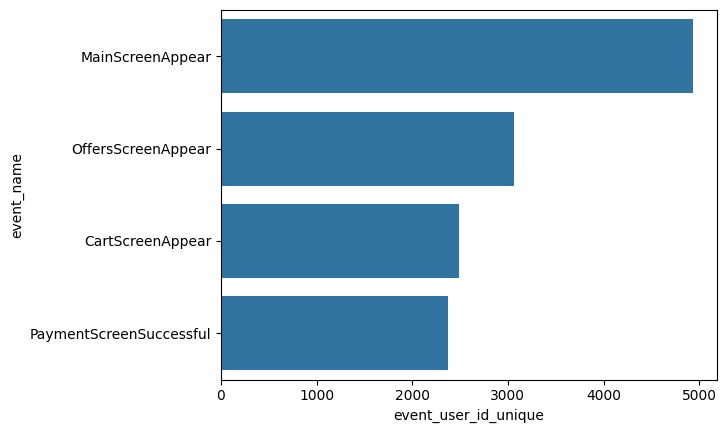

In [138]:
# визуализация воронки продаж

sns.barplot(data=df_funnel,
            y='event_name',
            x='event_user_id_unique')

In [139]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = df_funnel['event_name'],
    x = df_funnel['event_user_id_unique'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.show()

# Шаг 5. Анализ результатов эксперимента

- Сколько пользователей в каждой группе?
- Посчитайте долю пользователей, совершивших каждое из событий.
- Проверьте гипотезу о наличие значимых отличий по результатам теста.

In [140]:
# df_count_users
df_count_users = df[df.group_id != 247].groupby('group_id')\
                                       .user_id.nunique()
df_count_users.loc[246]

2480

In [141]:
2447 / 	2480

0.9866935483870968

In [142]:
df_pivot_event_group = df[df.group_id != 247].pivot_table(index='event_name',
                                                          columns='group_id',
                                                          values='user_id',
                                                          aggfunc='nunique')\
                                             .reset_index()\
                                             .sort_values(by=246, ascending=False)
df_pivot_event_group.columns = ['event_name', 'group_246', 'group_248']
df_pivot_event_group

# рассчитаем доли
for group_name in df_count_users.index:
    for col_name in ['group_246', 'group_248']:
        if col_name.find(str(group_name))>-1:
            df_pivot_event_group['part_users_'+str(group_name)] = np.round((df_pivot_event_group[col_name]
                                                                   / df_count_users.loc[group_name]),2)
df_pivot_event_group

,event_name,group_246,group_248,part_users_246,part_users_248
1,MainScreenAppear,2447,2491,0.99,0.98
2,OffersScreenAppear,1539,1529,0.62,0.60
0,CartScreenAppear,1263,1228,0.51,0.48
3,PaymentScreenSuccessful,1197,1179,0.48,0.47


Для биномиальных распределений

$$
\begin{multline*}
z = \dfrac{\dfrac{m_1}{n_1}+ \dfrac{1}{2n_1} - \dfrac{m_2}{n_2} - \dfrac{1}{2n_2}}{\sqrt{\dfrac{m_1+m_2}{n_1+n_2} \dfrac{n_1+n_2 - m_1 - m_2}{n_1+n_2}\left(\dfrac{1}{n_1}+\dfrac{1}{n_2}\right)}} = \\
= \dfrac{\dfrac{m_1}{n_1}- \dfrac{m_2}{n_2} + \dfrac{1}{2n_1} - \dfrac{1}{2n_2}}{\sqrt{\dfrac{m_1+m_2}{n_1+n_2} \left( 1-\dfrac{m_1+m_2}{n_1+n_2}\right)\left(\dfrac{1}{n_1}+\dfrac{1}{n_2}\right)}}
\end{multline*}
$$*Курсив*

In [143]:
df_count_users.loc[246]

2480

In [144]:
df_pivot_event_group.set_index(df_pivot_event_group.event_name,
                               inplace=True)
df_pivot_event_group

,event_name,group_246,group_248,part_users_246,part_users_248
event_name,,,,,
MainScreenAppear,MainScreenAppear,2447,2491,0.99,0.98
OffersScreenAppear,OffersScreenAppear,1539,1529,0.62,0.60
CartScreenAppear,CartScreenAppear,1263,1228,0.51,0.48
PaymentScreenSuccessful,PaymentScreenSuccessful,1197,1179,0.48,0.47


In [145]:
df_pivot_event_group.loc['MainScreenAppear', 'group_246']

2447

In [146]:
#для биноминальных распределений -- распределения Бернулли

def test_z_criterion(event_name, alpha):
    import scipy.stats as st
    import math

    n1 = df_count_users.loc[246]
    n2 = df_count_users.loc[248]

    m1 = df_pivot_event_group.loc[event_name, 'group_246']
    m2 = df_pivot_event_group.loc[event_name, 'group_248']

    z_value = (m1/n1 - m2/n2) / math.sqrt(((m1+m2)/(n1+n2))*(1-((m1+m2)/(n1+n2)))*(1/n1+1/n2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2 #1-F(t)
    print('Результаты проверки гипотезы H_0 по z-критерию:')
    print('Уровень значимости alpha={:.2f}'.format(alpha))
    print('P-value: {:.2f}'.format(p_value))
    if p_value < alpha:
        print(f"""Отвергаем нулевую гипотезу: разница в долях
по событию <<{event_name}>> статистически значима.""")
    else: print(f"""Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<{event_name}>> статистически незначима.""")
    print('------------------------------------------------------------')

In [147]:
alpha = 0.05

for col in df_pivot_event_group['event_name'].unique():
    test_z_criterion(col, alpha)


Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.34
Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<MainScreenAppear>> статистически незначима.
------------------------------------------------------------
Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.22
Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<OffersScreenAppear>> статистически незначима.
------------------------------------------------------------
Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.08
Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<CartScreenAppear>> статистически незначима.
------------------------------------------------------------
Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.22
Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<PaymentScreenSuccessful>> с

# С помощью Yandex DataLens создайте дашборд, отвечащий на следующие вопросы:
- сколько уникальных клиентов в группах 247 и 248;
- сколько уникальных клиентов совершили события по каждой группе;
- по каждой группе построить распределение количества событий по времени.

Ссылку на дашборд прикрепите к настоящей тетради.

In [148]:
# Сколько уникальных клиентов в группах 247 и 248
unique_clients_247 = df[df['group_id'] == 247]['user_id'].nunique()
unique_clients_248 = df[df['group_id'] == 248]['user_id'].nunique()
unique_clients_247

2510

In [149]:
print(f"Уникальные клиенты в группе 247: {unique_clients_247}")
print(f"Уникальные клиенты в группе 248: {unique_clients_248}")

Уникальные клиенты в группе 247: 2510
Уникальные клиенты в группе 248: 2533


In [150]:
# Сколько уникальных клиентов совершили события по каждой группе
unique_clients_per_group = df.groupby('group_id')['user_id'].nunique()

print("Уникальные клиенты по группам:")
print(unique_clients_per_group)

Уникальные клиенты по группам:
group_id
246    2480
247    2510
248    2533
Name: user_id, dtype: int64


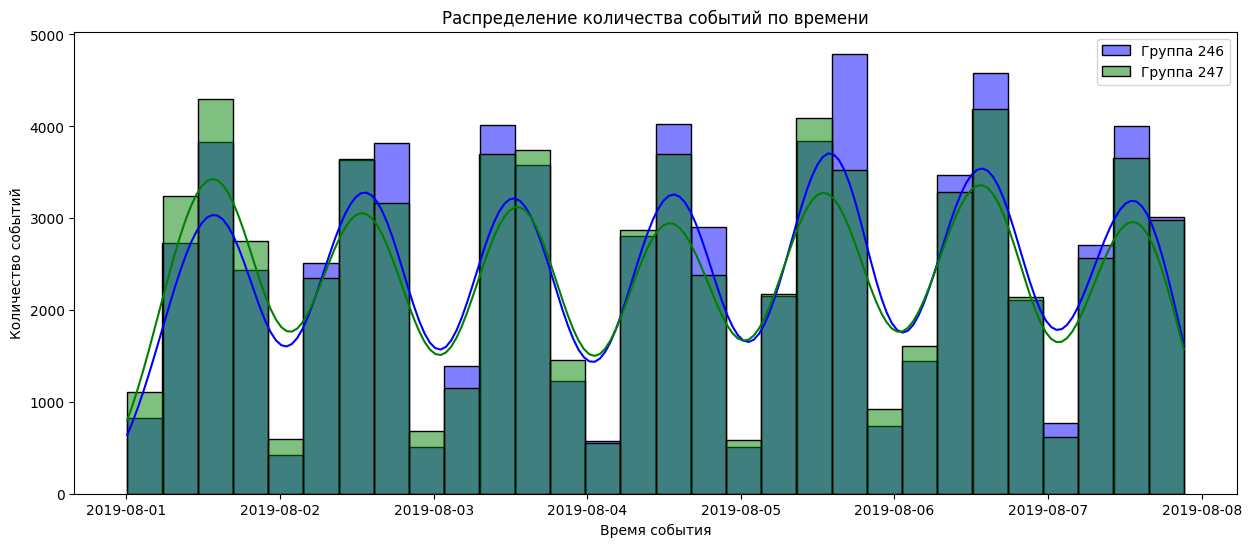

In [151]:
# Построение распределения количества событий по времени
plt.figure(figsize=(15, 6))

# Группа 246
sns.histplot(df[df['group_id'] == 246]['event_time'], bins=30, color='blue', label='Группа 246', kde=True)
# Группа 247
sns.histplot(df[df['group_id'] == 247]['event_time'], bins=30, color='green', label='Группа 247', kde=True)
# Группа 248
#sns.histplot(df[df['group_id'] == 248]['event_time'], bins=30, color='red', label='Группа 248', kde=True)

plt.title('Распределение количества событий по времени')
plt.xlabel('Время события')
plt.ylabel('Количество событий')
plt.legend()
plt.show()

С помощью Yandex DataLens создайте дашборд, отвечащий на следующие вопросы:
- сколько уникальных клиентов в группах 247 и 248;
- сколько уникальных клиентов совершили события по каждой группе;
- по каждой группе построить распределение количества событий по времени.

Ссылку на дашборд прикрепите к настоящей тетради.

https://datalens.yandex.cloud/1fdmsqru0nwoo

https://datalens.yandex.cloud/1fdmsqru0nwoo